First of all, I would like to show my appreciation to the owners' of the follwoing Notebooks that were extremly helpful:

https://www.kaggle.com/allunia/santander-customer-transaction-eda

https://www.kaggle.com/gpreda/santander-eda-and-prediction

https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment


# Introduction

In this challenge, the goal is to help Santander to predict if their clients will make a specific transaction.  The dataset provided by the bank is anonymised, and it is a representation of the real customer data. It is a binary classification problem, with 200 features and 200.000 samples.

This Notebook presents an overview of how the data was explored, analysed and prepared to be used on an ML model. 

# Part 1 - EDA

In [1]:
import pandas as pd
import numpy as np
#import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
random_state = 42
np.random.seed(random_state)
from sklearn.model_selection import cross_validate
# visualization
sns.set()

In [2]:
def data_load(filename):
    return pd.read_csv(filename)

def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d" %(size[0],size[1], sum_duplicates, sum_null))

#Plot Bar graph with all classes and percentages - Return number of Classes and Samples per class
def bar_plot(df, target):
    unique, counts = np.unique(target, return_counts = True)
    label = np.zeros(len(unique))
    for i in range(len(unique)):
        label[i] = (counts[i]/df.shape[0])*100
        plt.bar(unique,counts, color = ['burlywood', 'green'], edgecolor='black')
        plt.text(x = unique[i]-0.15, y = counts[i]+0.01*df.shape[0], s = str("%.2f%%" % label[i]), size = 15)
    plt.ylim(0, df.shape[0])
    plt.xticks(unique)
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.show()
    return unique, counts

#Plots Heatmap and top 10 and bottom correlated features
def feat_corr_analysis(corrmat):
    f, ax = plt.subplots(figsize =(9, 8)) 
    #1 Heatmap
    sns.heatmap(corrmat, vmin=0, vmax=0.2, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
    plt.title("Heatmap - Correlation between data variables")
    #2 Correlation Values and Features
    correlations = corrmat.abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    #Top 10 correlated features
    correlations.tail(10)
    #Bottom 10 correlated features
    correlations.head(10)
    return correlations.tail(10)

def feat_corr_distr(train,test):
    #Plot distribution of Feature Correlation
    train_corr_distr = train.values.flatten()
    train_corr_distr = train_corr_distr[train_corr_distr != 1]
    test_corr_distr = test.values.flatten()
    test_corr_distr = test_corr_distr[test_corr_distr != 1]
    plt.figure(figsize=(20,5))
    sns.distplot(train_corr_distr, color="Red", label="Train")
    sns.distplot(test_corr_distr, color="black", label="Test")
    plt.xlabel("Correlation values")
    plt.ylabel("Density")
    plt.title("Feature Correlation"); 
    plt.legend();
    
def prediction(x_train,y_train):
    classifier.fit(x_train,y_train)
    y_proba = classifier.predict_proba(x_train)
    plt.figure(figsize=(20,5))
    y_pred = classifier.predict(x_train)
    y_proba = classifier.predict_proba(x_train)
    score = roc_auc_score(y_train, y_pred)
    return y_proba, score

def probability_class(y_proba):
    plt.figure(figsize=(20,5))
    sns.distplot(y_proba[y_train==1,1], label="True Class 1")
    sns.distplot(y_proba[y_train==0,1], label="True Class 0")
    plt.xticks(np.arange(0,1, 0.1))
    plt.xlabel("Predicted probability values of class 1")
    plt.ylabel("Density")
    plt.title("Predicted probability values of class 1 against the true Target"); 
    plt.legend();

Importing the Training and Test set CSV files.

In [3]:
#Load Data
train = data_load('../input/santander-customer-transaction-prediction/train.csv')
test = data_load('../input/santander-customer-transaction-prediction/test.csv')

## Overview
For an overview of the data, it is analysed the number of samples, features, duplicated and null values:

In [4]:
print("***Train EDA***")
train_EDA = basic_EDA(train)
print("***Test EDA***")
test_EDA  = basic_EDA(test)


***Train EDA***
Number of Samples: 200000,
Number of Features: 202,
Duplicated Entries: 0,
Null Entries: 0
***Test EDA***
Number of Samples: 200000,
Number of Features: 201,
Duplicated Entries: 0,
Null Entries: 0


This is a large dataset, with 200.000 samples and over 200 features. No null values or duplicated entries were found, eliminating the need for data cleanse at this stage. It is also fundamental to understand the type of variables present in this dataset:

In [5]:
train.info()
train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


The "target" column contains the true labels. The "ID_CODE" is the object dtype mentioned in the info(). Other than this, all values are numeric for train and test sets. Therefore there is no need for enconding.

In [6]:
test.info()
test.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
5,test_5,5.9862,-2.2913,8.6058,7.0685,14.2465,-8.6761,4.2467,14.7632,1.8790,...,-2.1115,7.1178,-0.4249,8.8781,14.9438,-2.2151,-6.0233,9.8117,17.1127,10.8240
6,test_6,8.4624,-6.1065,7.3603,8.2627,12.0104,-7.2073,4.1670,13.0809,-4.3004,...,12.3609,6.8661,4.0971,8.8484,17.5010,0.0295,7.7443,9.1509,18.4736,5.1499
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,...,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
8,test_8,6.9856,0.8402,13.7161,4.7749,8.6784,-13.7607,4.3386,14.5843,2.5883,...,-3.4657,7.8754,2.4698,-0.0362,16.7144,0.1221,-1.4328,9.9207,16.9865,-3.3304
9,test_9,10.3811,-6.9348,14.6690,9.0941,11.9058,-10.8018,3.4508,20.2816,-1.4112,...,1.8052,11.0723,0.8907,4.7680,15.1425,0.6075,-4.4447,9.5788,15.8146,9.3457


At this point, it is possible to remove the ID_code column and replace it with a numerical index that can be easily handled by the ML models. The new column is called Id.

In [7]:
#ID_Code is the only object dtype. It can be replaced by index values
train["Id"] = train.index.values
test["Id"] = test.index.values
init_train_ID = train.ID_code.values
init_test_ID = test.ID_code.values
train.drop("ID_code", axis=1, inplace=True)
test.drop("ID_code", axis=1, inplace=True)
train.head(5)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,Id
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,0
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,1
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,2
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,3
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,4


## Samples per Class
By analysing the samples per class ratio it is possible to see the class imbalance issue. Almost 90% of the samples are clients that did not performed the transaction. 

* An initial attempt was made to use SMOTE and ADASYN as oversampling methods. Preliminary test have shown that this did not helped the model to generalise to the test set.

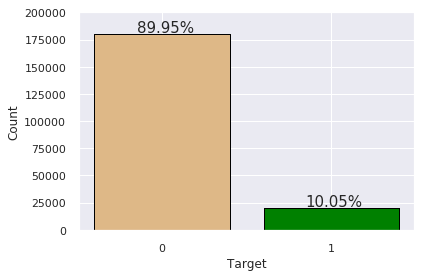

In [8]:
##Visualise Class Imbalance - Training Set
num_classes, feat_per_class = bar_plot(train, train["target"])

## Feature Correlation
Since this dataset has a significant amount of features, this analysis helps to develop an understanding of how the variable relate to each other. This can indicate starting points for feature engineering and the most relevant variables for the model. 

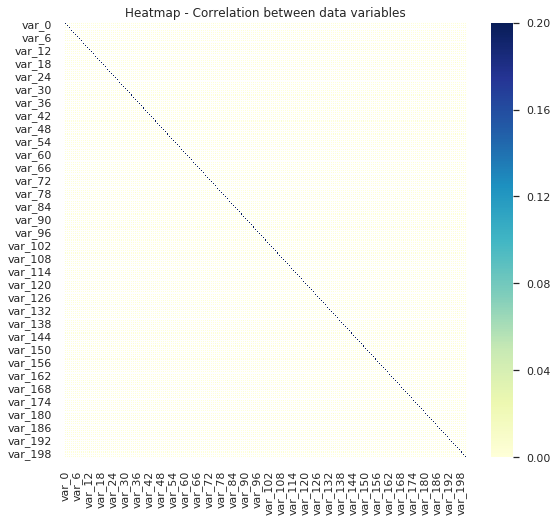

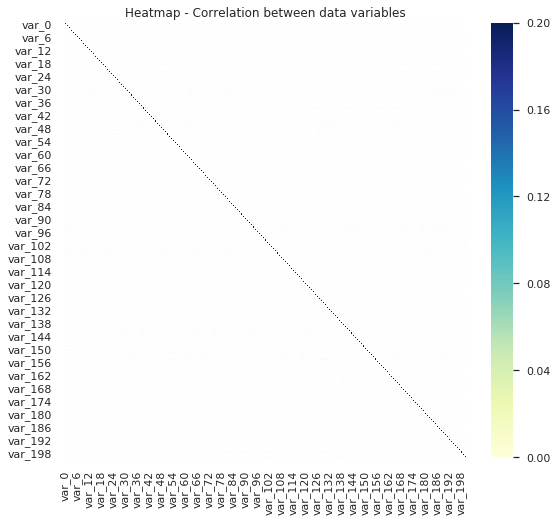

In [9]:
train_corrmat = train.drop(["target"], axis=1).corr()
feat_corr_train = feat_corr_analysis(train_corrmat)
test_corrmat = test.corr()
feat_corr_test = feat_corr_analysis(test_corrmat)


There is none or very little correlation between the features for training and test sets. The plot below shows that the correlation values distribution is similar for the train and test set.

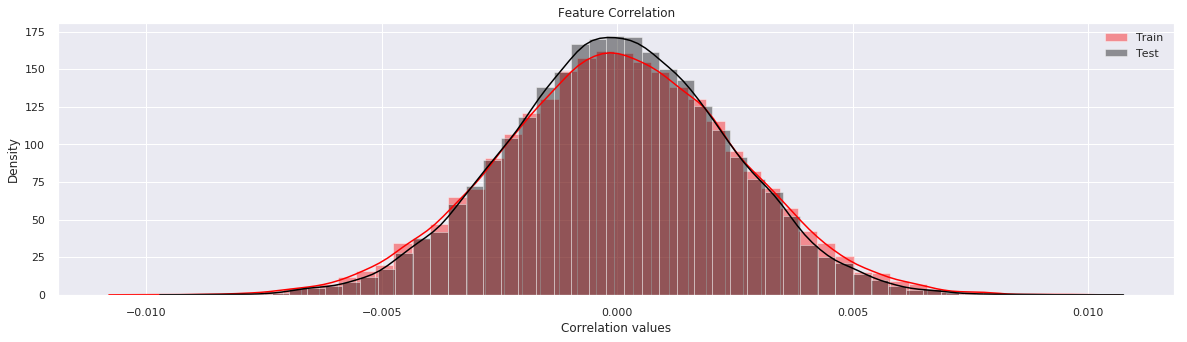

In [10]:
feat_corr_distr(train_corrmat, test_corrmat)

From the EDA, it was possible to conclude:
* No major data cleanse method was required, as the data was mostly numerical and there were no missing or duplicated entries;
* There is little or no variance between the variables, which renders difficult to define the feature engineering path;
* The data imbalance issue needs to be addressed.

# Part 2 - Model Baseline
Random Forest (RF) algorithm is used as a starting point to allow a better understanding of this dataset. RF is quick, and it does not have that many parameters to tune and usually provide reasonable results. By understanding what works and what does not works with RF, it is possible to improve the model quicker and then try other algorithms. This first step is mainly to understand the top essential features,  trial some feature engineering and sampling techniques.

In [11]:
#Prepare DF
X_train = train.drop("target", axis=1).values
y_train = train.target.values

In [12]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(test)

Below is the RF classifier. Grid Search supported the selection of the initial parameters:

In [13]:
#Random Forest Baseline Model
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators = 10, 
                       criterion = 'gini',
                       max_depth = 15, 
                       max_features = 'auto', 
                       min_samples_leaf = 1, 
                       random_state = 0)

The code below creates the RF model and outputs the AUC result for the training set. It also outputs the probabilities of each sample belonging to class 0 or 1.

In [14]:
RF_y_proba, RF_model_score = prediction(X_train,y_train)
print("Baseline RF: %.2f "%(RF_model_score))
pd.DataFrame(RF_y_proba).describe()


Baseline RF: 0.55 


,0,1
count,200000.000000,200000.000000
mean,0.902051,0.097949
std,0.084449,0.084449
min,0.000000,0.028639
25%,0.906576,0.057355
50%,0.930047,0.069953
75%,0.942645,0.093424
max,0.971361,1.000000


<Figure size 1440x360 with 0 Axes>

RF_y_proba contains the probability of class 0 and 1 for every sample. Most values for class 1 are small, and the majority does not reach 0.1, as shown by the table above. One hypothesis can be that the usual threshold of 0.5 is not ideal for this model to assign class 1 or 0. One way to visualise this is to plot the "Class 1" probability distribution for all samples, according to their True label. 

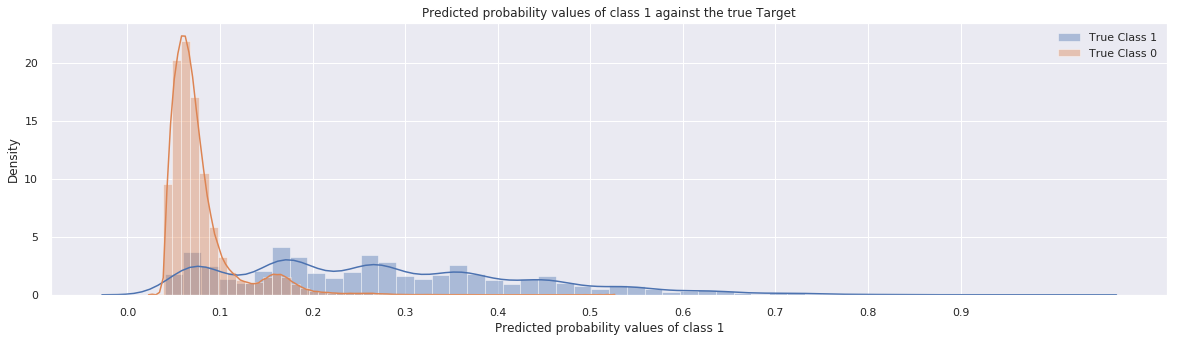

In [15]:
probability_class(RF_y_proba)

From the plot above it is possible to extract the following insights:
* Most of the True Class 1 samples were predicted by our model with a probability lower than 0.5
* Most of the True Class 0 samples are concentrated within the values of 0 and 0.15
* For samples with Class 1 probability values higher than approximately 0.15, it is almost safe to say they are True Class 1. Altough there is the orange bump around 0.17
* It is possible to perform a quick test and see if this helps the model accuracy:

In [16]:
#From the graph, used a threshold of 0.15
threshold = 0.15
y_pred = np.zeros(RF_y_proba.shape[0])
y_pred[RF_y_proba[:,1] >= threshold] = 1
RFT_model_score = roc_auc_score(y_train, y_pred)
print("Baseline RF: %.2f \nThreshold RF: %.2f"%(RF_model_score, RFT_model_score))

Baseline RF: 0.55 
Threshold RF: 0.85


A 30% increase in accuracy was achieved by this simple but effective strategy. This is something to keep in mind in the future and check if other models also present this behaviour.

## Feature Importances
This analysis can helps reduce the number of features while mantaining the minimum impact on model accuracy. Using the RF classifier, the following features are more effective to our model:


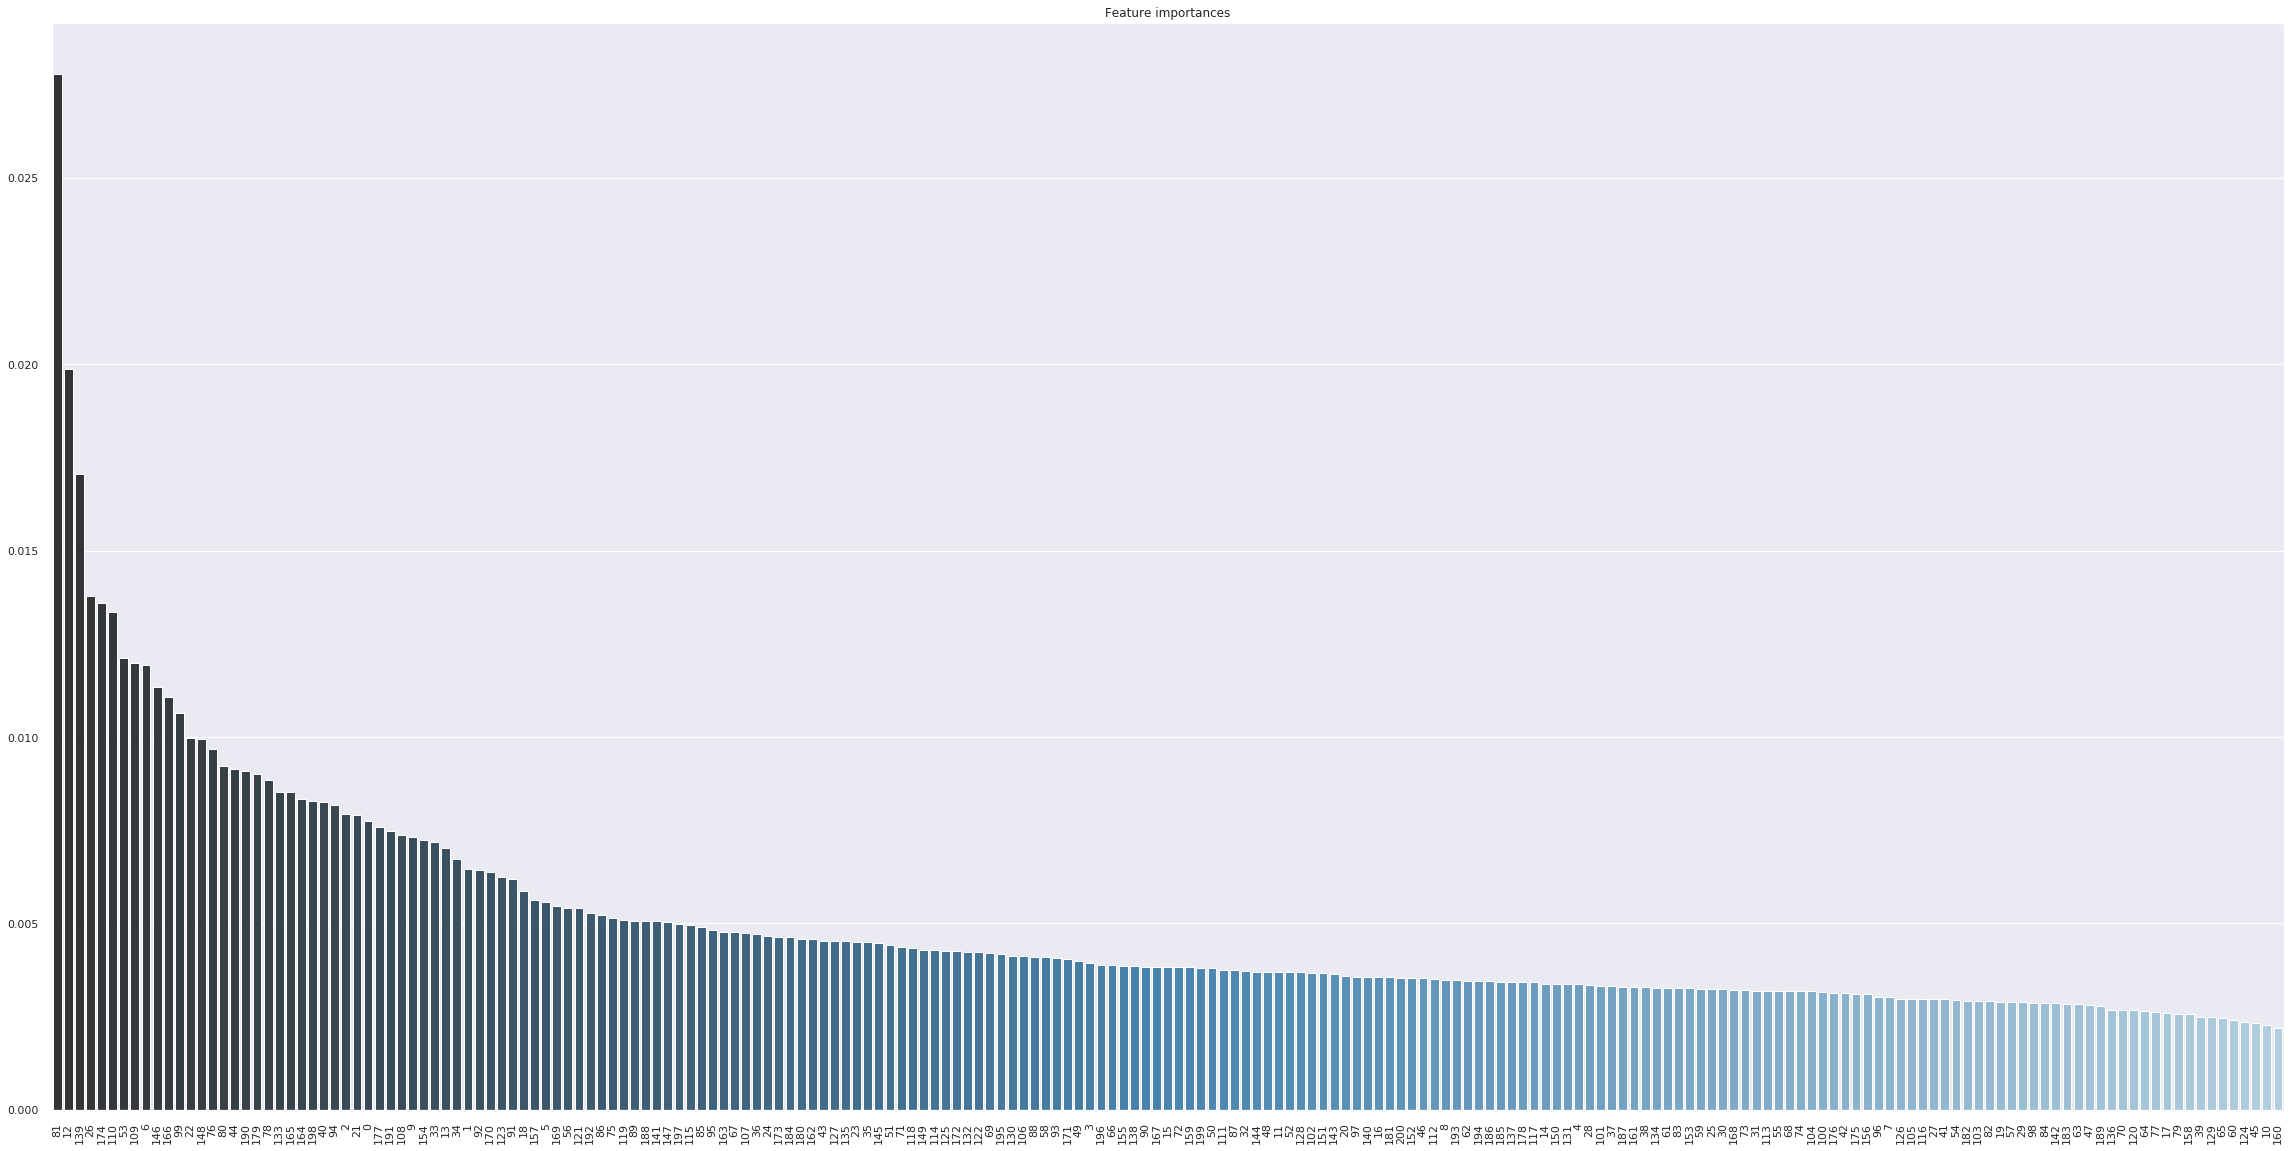

In [17]:
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
colors = plt.cm.Reds(importances)
# Plot the feature importances
plt.figure(1, figsize=(40,20))
plt.title("Feature importances")
sns.barplot(x=indices, y=importances[indices], order = indices,palette="Blues_d")
plt.xticks(rotation = 90)
plt.show()

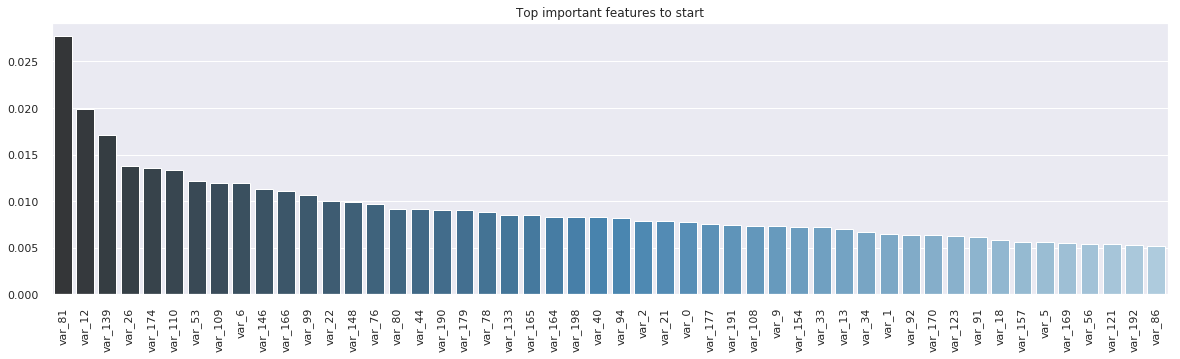

In [18]:
#From the Feature Importances, we can see that 
n_top = 50
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train.drop("target", axis=1).columns.values
plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx],palette="Blues_d");
plt.title("Top important features to start");
plt.xticks(rotation = 90)
plt.show()

In [19]:
pd.DataFrame(X_train[:,idx]).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,...,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05
mean,1.912559e-17,5.643389e-15,3.171741e-17,5.056344e-17,4.070944e-16,3.730080e-16,5.944856e-17,2.670175e-16,-9.260245e-17,2.496425e-16,...,1.393097e-16,5.772494e-17,1.122255e-16,-2.144929e-16,1.478817e-17,1.113065e-15,-5.348766e-16,-7.505557e-16,1.215494e-16,-3.078648e-18
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-3.101689e+00,-3.101029e+00,-3.777378e+00,-3.408866e+00,-3.251772e+00,-3.858775e+00,-3.483053e+00,-2.913489e+00,-3.532923e+00,-3.935793e+00,...,-3.169206e+00,-3.051236e+00,-3.299842e+00,-3.263197e+00,-3.496937e+00,-3.727867e+00,-3.917152e+00,-2.919596e+00,-3.884107e+00,-3.211568e+00
25%,-6.541460e-01,-6.838822e-01,-6.989759e-01,-7.204409e-01,-7.211017e-01,-7.050984e-01,-7.492226e-01,-7.694169e-01,-7.399549e-01,-6.726323e-01,...,-6.928543e-01,-7.707105e-01,-7.726139e-01,-7.407912e-01,-7.802162e-01,-7.075877e-01,-7.150203e-01,-7.665550e-01,-7.021442e-01,-6.726133e-01
50%,5.456525e-02,8.009110e-03,3.981788e-02,-2.393821e-02,-6.413293e-04,-3.110918e-02,2.514701e-02,-4.056265e-02,-2.751966e-02,2.160570e-02,...,2.570977e-02,-6.823032e-03,-6.083412e-03,-9.846631e-03,2.952565e-02,-4.624198e-03,5.362776e-03,-4.135008e-02,-1.795060e-02,4.975300e-02
75%,7.052546e-01,7.377834e-01,7.119486e-01,6.695040e-01,7.609637e-01,6.777195e-01,6.986995e-01,7.795369e-01,6.854925e-01,7.035069e-01,...,7.578082e-01,7.459272e-01,7.348178e-01,6.866786e-01,7.617868e-01,7.291971e-01,7.515286e-01,7.634302e-01,6.910499e-01,7.143890e-01
max,3.658687e+00,3.317512e+00,3.686623e+00,3.331574e+00,3.270009e+00,3.663397e+00,2.906738e+00,3.123085e+00,3.506501e+00,4.008184e+00,...,3.220691e+00,3.288506e+00,3.375723e+00,3.013442e+00,2.838130e+00,3.933000e+00,3.515355e+00,3.497881e+00,4.379381e+00,3.733993e+00


The next model is built using the top 50 features. Additional features were created performing the following operations per row: 

<Figure size 1440x360 with 0 Axes>

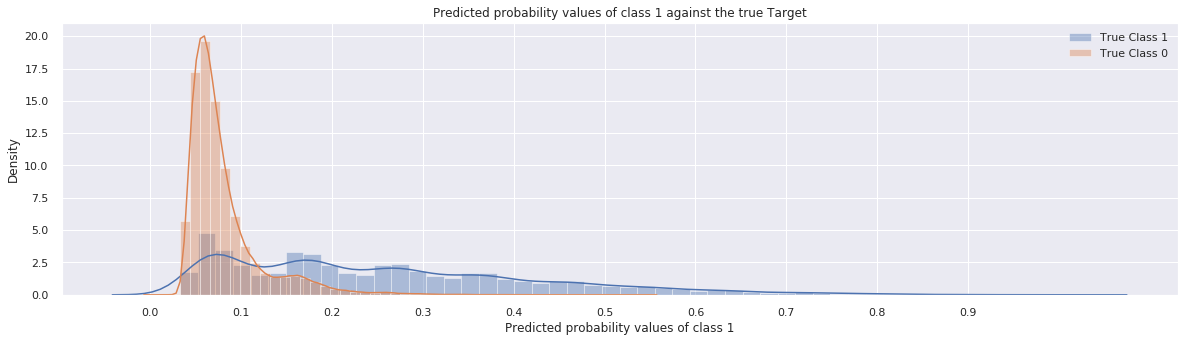

In [20]:
X_train_top = X_train[:,0:n_top]
sum_feat= X_train_top.sum(axis=1)
min_feat = X_train_top.min(axis=1)
max_feat = X_train_top.max(axis=1)
mean_feat = X_train_top.mean(axis=1)
std_feat = X_train_top.std(axis=1)
X_train_top = np.concatenate((X_train_top,
                             sum_feat[:,None],
                             min_feat[:,None],
                             max_feat[:,None],
                             mean_feat[:,None],
                             std_feat[:,None]),
                             axis = 1)
RF1_y_proba, RF1_model_score = prediction(X_train_top, y_train)
probability_class(RF1_y_proba)

With the new features, is necessary to revaluate and assign a new threshold 

In [21]:
RF1_y_pred = np.zeros(RF1_y_proba.shape[0])
RF1_y_pred[RF1_y_proba[:,1] >= 0.12] = 1
RF1_model_score = roc_auc_score(y_train, y_pred)
print("Baseline RF %.2f\nThreshold RF %.2f\nThreshold RF with only top features %.2f"%(RF_model_score, RFT_model_score, RF1_model_score))

Baseline RF 0.55
Threshold RF 0.85
Threshold RF with only top features 0.85


# Part 3 - Submission
By reducing the number of features to a quarter of the original model, the same accuracy was mantained. 

At this point is interesting to check our score in the test set and submit:

In [22]:
X_test_top = X_test[:,idx]
X_test_top = X_test[:,0:n_top]
sum_feat= X_test_top.sum(axis=1)
min_feat = X_test_top.min(axis=1)
max_feat = X_test_top.max(axis=1)
mean_feat = X_test_top.mean(axis=1)
std_feat = X_test_top.std(axis=1)
X_test_top = np.concatenate((X_test_top,
                             sum_feat[:,None],
                             min_feat[:,None],
                             max_feat[:,None],
                             mean_feat[:,None],
                             std_feat[:,None]),
                             axis = 1)
#####################################################
y_proba = classifier.predict_proba(X_test_top)
y_pred = np.zeros(y_proba.shape[0])
y_pred[y_proba[:,1] >= 0.12] = 1
submission = pd.concat([pd.DataFrame(init_test_ID),pd.DataFrame(y_pred)],axis = 1)
submission.columns = ['ID_code', 'Target']
submission.to_csv("submission_RForest.csv", index=False)

## Conclusion

This concludes a quick analysis on the Santander Customer Transaction Challenge. The result on the test set points to overfitting, since it only achieved **0.59** on the test set while **0.85** on the training set.

On the following days, I want to devote more attention to other models and improve feature engineering. I noticed many challenge submissions using Light GBM and ANN. It is also essential to implement an ensemble, as this usually improves the overall model score.